In [1]:
from landlab.io import read_esri_ascii
import numpy as np

from matplotlib import pyplot as plt

from landlab import RasterModelGrid, imshow_grid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerSmoothThresholdEroder,
)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['figure.facecolor']='white'

In [2]:
(mg, z) = read_esri_ascii("land_pre_river_natural.asc", name="topographic__elevation")

#https://landlab.readthedocs.io/en/master/user_guide/field_io.html
#tutorial https://github.com/landlab/landlab/blob/master/notebooks/teaching/...
#         geomorphology_exercises/channels_streampower_notebooks/stream_power_channels_class_notebook.ipynb

(_, K_sp) = read_esri_ascii("ksp_coeff_nonan.asc")

xy_up = mg.xy_of_node
xy_up.setflags(write=1)
xy_up[:,1] = xy_up[:,1] - np.amin(xy_up[:,1])
xy_up[:,0] = xy_up[:,0] - np.amin(xy_up[:,0])

uplift_rate = 0.00165-(xy_up[:,0] + 4*xy_up[:,1])/(54100*5*1000)
print(uplift_rate)
print(K_sp)

#(_, uplift_rate) = read_esri_ascii("uplift_coeff_metre_p_year_nonan.asc")
#uplift_rate = np.ones(mg.number_of_nodes) * 0.0001

[ 0.00165     0.00164963  0.00164926 ...,  0.00065259  0.00065222
  0.00065185]
[  2.00000000e-05   2.00000000e-05   2.00000000e-05 ...,   3.00000000e-05
   3.00000000e-05   3.00000000e-05]


In [3]:
# Add noise to DEM data

np.random.seed(35)  # seed set so our figures are reproducible
mg_noise = (
    np.random.randn(mg.number_of_nodes)/5
)  # intial noise on elevation gri

# elevation plus noise
z += mg_noise

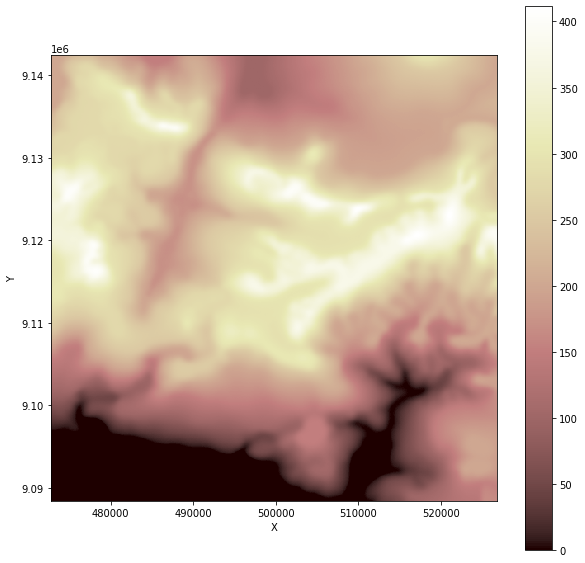

In [4]:
min_z = np.min(z[np.where(z != 1.70141000000000007E+38)])
max_z = np.max(z[np.where(z != 1.70141000000000007E+38)])
#help(imshow_grid)
imshow_grid(mg, 'topographic__elevation', limits=(0, max_z))

In [5]:
z[np.where(z == 1.70141000000000007E+38)] = np.nan
K_sp[np.where(K_sp == 1.70141000000000007E+38)] = 0
ksp_noise = (np.random.randn(mg.number_of_nodes) / 2e+5)  # intial noise on elevation grid
K_sp += ksp_noise
uplift_rate[np.where(uplift_rate == 1.70141000000000007E+38)] = 0

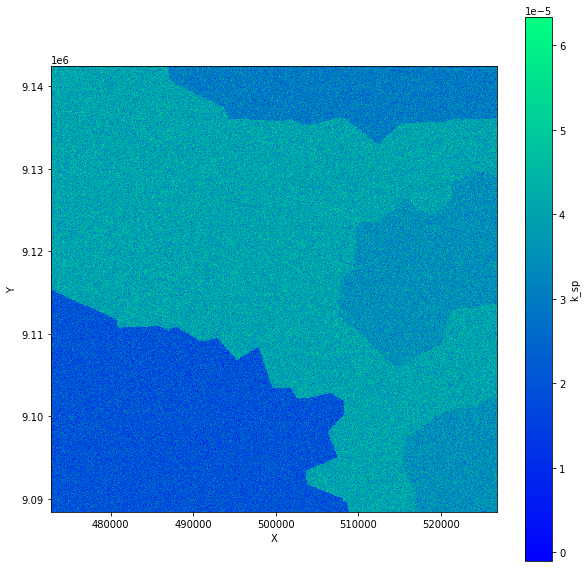

In [6]:
k_field = mg.add_field('linear_diffusivity', K_sp, at='node', clobber=True)
imshow_grid(mg, K_sp, var_name='k_sp', cmap='winter')

In [7]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
#mg.set_nodata_nodes_to_closed(z, -9)
#mg.status_at_node[4087] = mg.BC_NODE_IS_FIXED_VALUE
#mg.status_at_node[19] = mg2.BC_NODE_IS_FIXED_VALUE

In [8]:
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

frr = FlowAccumulator(mg, flow_director="FlowDirectorD8", depression_finder="DepressionFinderAndRouter")  # intializing flow routing
spr = StreamPowerSmoothThresholdEroder(
    mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.5
)  # initializing stream power incision

theta = m_sp / n_sp
# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg, reference_concavity=theta, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf = ChiFinder(mg, min_drainage_area=100.0, reference_concavity=theta, use_true_dx=True)

In [9]:
tmax = 3.8e4  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 2000 # time step [yr] (Original value was 100 yr)
total_time = 0  # amount of time the landscape has evolved [yr]
# total_time will increase as you keep running the code.

t = np.arange(total_time, tmax, dt)  # each of the time steps that the code will run

In [10]:
for ti in t:
    z[mg.core_nodes] += uplift_rate[mg.core_nodes] * dt  # uplift the landscape
    frr.run_one_step()  # route flow
    spr.run_one_step(dt)  # fluvial incision
    total_time += dt  # update time keeper
    if total_time%10000==0:
        print(total_time)

10000
20000
30000


In [11]:
#detailed river evolution

tmax = 3.94e4
dt = 100
t = np.arange(total_time, tmax, dt)

for ti in t:
    z[mg.core_nodes] += uplift_rate[mg.core_nodes] * dt  # uplift the landscape
    frr.run_one_step()  # route flow
    spr.run_one_step(dt)  # fluvial incision
    total_time += dt  # update time keeper
    if total_time%100==0:
        print(total_time)

38100
38200
38300
38400
38500
38600
38700
38800
38900
39000
39100
39200
39300
39400


In [12]:
tmax = 3.949e4
dt = 10
t = np.arange(total_time, tmax, dt)

for ti in t:
    z[mg.core_nodes] += uplift_rate[mg.core_nodes] * dt  # uplift the landscape
    frr.run_one_step()  # route flow
    spr.run_one_step(dt)  # fluvial incision
    total_time += dt  # update time keeper
    if total_time%10==0:
        print(total_time)

39410
39420
39430
39440
39450
39460
39470
39480


Maximum elevation is  453.409023882


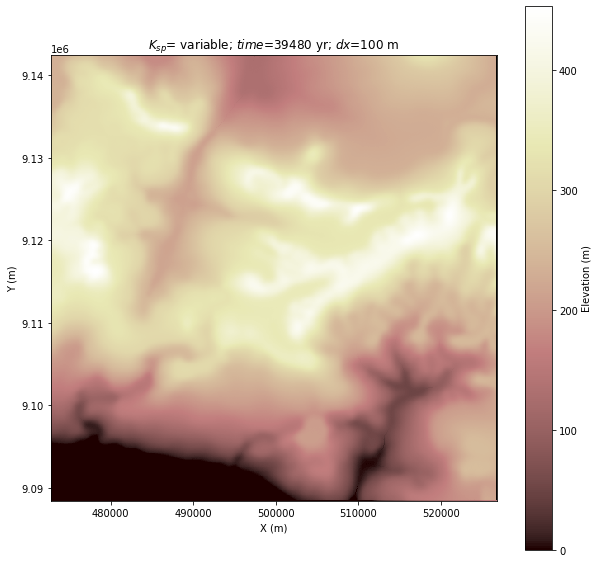

In [13]:
min_z = np.nanmin(z)
max_z = np.nanmax(z)

imshow_grid(mg, "topographic__elevation", grid_units=("m", "m"), var_name="Elevation (m)", limits=(0, max_z))
title_text = f"$K_{{sp}}$= variable; $time$={total_time} yr; $dx$=100 m"
plt.title(title_text)

max_elev = np.nanmax(z)
print("Maximum elevation is ", np.nanmax(z))

Text(0.5, 1.0, 'Sadeng River flow captured by the Solo River')

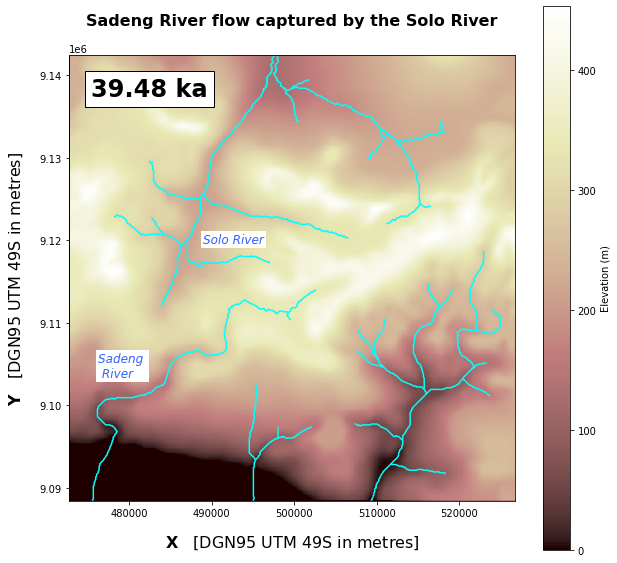

In [14]:
# profile the largest channels, set initially to find the mainstem channel in the three biggest watersheds
# you can change the number of watersheds, or choose to plot all the channel segments in the watershed that
# have drainage area below the threshold (here we have set the threshold to the area of a grid cell).
prf = ChannelProfiler(
    mg,
    number_of_watersheds=5,
    main_channel_only=False,
    minimum_channel_threshold=4000**2,
)
prf.run_one_step()

# plot the location of the channels in map view
plt.figure(2)
prf.plot_profiles_in_map_view(color="cyan", var_name="Elevation (m)", limits=(0, max_z))
ax = plt.gca()
txt_year = str(total_time/1000)+' ka'
ax.text(0.05, 0.95, txt_year, style='normal', fontweight='bold', fontsize=24, horizontalalignment='left',
        verticalalignment='top', bbox={'facecolor': 'white', 'pad': 6}, transform=ax.transAxes)
ax.text(0.3, 0.6, 'Solo River', style='italic', fontsize=12, color='#3262fc', horizontalalignment='left',
        verticalalignment='top', bbox={'facecolor': 'white', 'pad': 2, 'edgecolor': 'None'}, transform=ax.transAxes)
ax.text(0.065, 0.335, 'Sadeng \n River', style='italic', fontsize=12, color='#3262fc', horizontalalignment='left',
        verticalalignment='top', bbox={'facecolor': 'white', 'pad': 2, 'edgecolor': 'None'}, transform=ax.transAxes)
plt.xlabel("$\mathbf{X}$   [DGN95 UTM 49S in metres]", fontsize=16, labelpad=15)
plt.ylabel("$\mathbf{Y}$   [DGN95 UTM 49S in metres]", fontsize=16, labelpad=15)
plt.title('Sadeng River flow captured by the Solo River', fontweight='bold', fontsize=16, pad=30)